## Libraries

In [50]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import tarfile
import os
import random
from skimage.metrics import structural_similarity as ssim

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model

print('All the libraries are loaded')

All the libraries are loaded


## Preliminary 

In [2]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "lfw.tgz"

In [43]:
### Data Loader
'''
The code of the data loaded is being taken from the website
https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
'''
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.notebook.tqdm(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

### Model
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

### Visualizations
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(np.clip(img, 0, 1))

#     plt.subplot(1,3,2)
#     plt.title("Code")
#     plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(np.clip(reco, 0, 1))
    plt.show()
    
    print('-'*30,'SSIM:',ssim(img[0],reco[0],multichannel=True),'-'*30)
    
    return

### Metric
def overall_ssim(actual,predicted):
    assert len(actual)==len(predicted)
    results = []
    for i in range(len(actual)):
        s = ssim(actual[i],predicted[i],multichannel=True)
        results.append(s)
    results = np.array(results)
    return np.mean(results)

## Main

### Data Preparation

In [8]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
X = X.astype('float32') / 255.0

Text(0.5, 1.0, 'Image:1651')

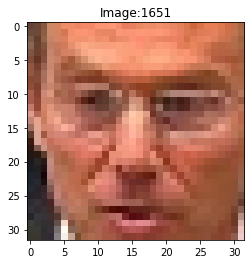

In [32]:
num = random.randint(0,len(X))

plt.imshow(np.clip(X[num], 0, 1))
plt.title(f'Image:{num}')

### Data Split

In [60]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')

The shape of X_train is (11828, 32, 32, 3)
The shape of X_test is (1315, 32, 32, 3)


### Model Training

In [61]:
IMG_SHAPE = X.shape[1:]
embed_size =1000
encoder, decoder = build_autoencoder(IMG_SHAPE, embed_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse',metrics=['mae'])

print(autoencoder.summary())

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 1000)              3073000   
_________________________________________________________________
sequential_11 (Sequential)   (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0048 - mae: 0.0532 - val_loss: 0.0041 - val_mae: 0.0493
Epoch 2/50
296/296 [==============================] - 1s 2ms/step - loss: 0.0038 - mae: 0.0469 - val_loss: 0.0040 - val_mae: 0.0488
Epoch 3/50
296/296 [==============================] - 1s 2ms/step - loss: 0.0034 - mae: 0.0447 - val_loss: 0.0029 - val_mae: 0.0410
Epoch 4/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0028 - mae: 0.0406 - val_loss: 0.0073 - val_mae: 0.0674
Epoch 5/50
296/296 [==============================] - 1s 2ms/step - loss: 1.6723 - mae: 0.3649 - val_loss: 0.0046 - val_mae: 0.0523
Epoch 6/50
296/296 [==============================] - 1s 2ms/step - loss: 0.0035 - mae: 0.0454 - val_loss: 0.0032 - val_mae: 0.0435
Epoch 7/50
296/296 [==============================] - 1s 2ms/step - loss: 0.0053 - mae: 0.0544 - val_loss: 0.0064 - val_mae: 0.0651
Epoch 8/50
296/296 [==============================] - 1s 2ms/step - loss: 0.

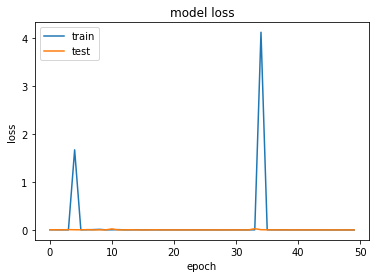

In [66]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=50,validation_split=0.2,batch_size=32)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predictions

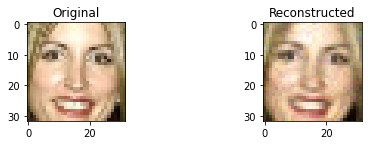

------------------------------ SSIM: 0.8016698119382627 ------------------------------


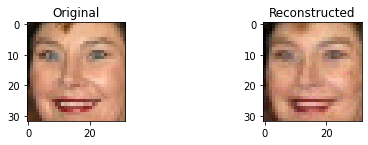

------------------------------ SSIM: 0.899625296828319 ------------------------------


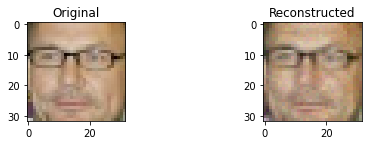

------------------------------ SSIM: 0.8825011322731641 ------------------------------


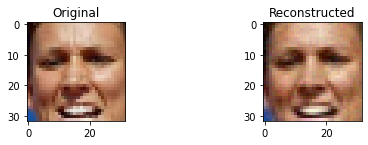

------------------------------ SSIM: 0.8928167452563162 ------------------------------


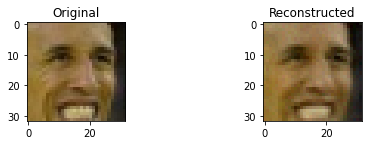

------------------------------ SSIM: 0.9327272855313807 ------------------------------


In [67]:
num_test = random.sample(range(0,len(X_test)),5)
for i in num_test:
    img = X_test[i]
    visualize(img,encoder,decoder)

In [68]:
bottle = encoder.predict(X_test)
predicted = decoder.predict(bottle)

print(f'The average Similarity image is : {round(overall_ssim(X_test,predicted),2)}')
print(f'The compression rate is: {round((np.prod(IMG_SHAPE)/embed_size),2)}')

The average Similarity image is : 0.94
The compression rate is: 3.07


## Experiment

In [ ]:
show_image(X_test[0])
plt.savefig('original.jpg')

In [ ]:
random = X_test[0]
random=np.expand_dims(random,axis=0)
random.shape

In [ ]:
bottle = encoder.predict(random)
bottle.shape

In [ ]:
new_image = decoder.predict(bottle)
new_image.shape

In [ ]:
plt.imshow(new_image[0])
plt.savefig('reconstructed.jpg')

In [ ]:
s = ssim(random[0], new_image[0],multichannel=True)

In [ ]:
s

In [ ]:
random.sample(range(0, 1000), 10)